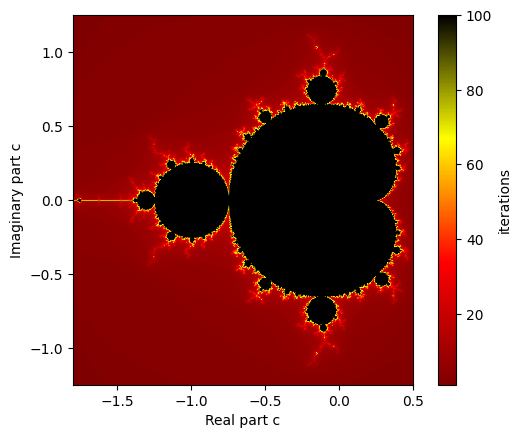

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import random as rd
import itertools
from scipy.stats import qmc

# set graph size and axes
width, height = 500, 500
x_min, x_max = -1.8, 0.5 
y_min, y_max = -1.25, 1.25

# custom coloring 
colors = [(0.5, 0, 0), (1, 0, 0),(1, 1, 0),(0, 0, 0)]     
name = "nicemap"
cmap = LinearSegmentedColormap.from_list(name, colors)

# max iterations we test for to let it escape, increase for more detail
max_iterations = 100

# empty set to store iteration counts
mandelbrot_set = np.zeros((height, width))

# Iterate over each pixel in the image
for i in range(width):
    for pixel in range(height):
        # position to complex number. complex(computes real part, computes imaginary part) 
        c = complex(x_min + (i / width) * (x_max - x_min),
                    y_min + (pixel / height) * (y_max - y_min))
        # set z at time 0 = 0 
        z = 0 
        # keep count of iterations
        iteration = 0
        
        # mandelbrot where we set a threshold that is equal to 2 and apply formula
        while abs(z) <= 2 and iteration < max_iterations:
            z = z**2 + c 
            iteration += 1
            
        # store iterations
        mandelbrot_set[pixel, i] = iteration

# plot
plt.imshow(mandelbrot_set, cmap, extent=(x_min, x_max, y_min, y_max))
plt.colorbar(label="iterations")
plt.xlabel("Real part c")
plt.ylabel("Imaginary part c")
plt.show()

In [ ]:
n_it = [1, 10, 100, 1000, 10000, 100000, 1000000] 
n_sample = [10, 100, 100, 1000, 10000, 100000, 1000000, 1000000]
# complex plain boundaries: y_min, y_max

def calculate_Am(): 
    pass 



def mandel_check(complex_number, max_iteration): 
    z = 0
    for i in range(max_iteration): 
        z = z**2 + complex_number
        if abs(z) > 2: 
            return False
    return True

def monte_carlo(n_samples, sample_type,  n_iterations, y_min, y_max, x_min, x_max): 
    true_count = 0      

    if sample_type == "lhs": 
        points = lhs_qmc(n_samples, y_min, y_max, x_min, x_max)
    elif sample_type == "orthogonal":
        points = orthogonal_sample(n_samples, x_min, x_max, y_min, y_max)
    elif sample_type == "pure_random": 
        points = pure_radom_sample(y_min, y_max, x_min, x_max, n_samples)


    for i in range(len(points)): 
        x_coordinate, y_coordinate, complex_element = points[i][0], points[i][1], points[i][2]

        if mandel_check(complex_element, n_iterations):
            true_count +=1 

    area_total = (x_max-x_min)*(y_max-y_min)
    mandel_area = (true_count/n_samples) * area_total
    print(f"Estimated area for {n_samples} samples and {n_iterations} iterations: {mandel_area}")
    return mandel_area

def pure_radom_sample(y_min, y_max, x_min, x_max, n_samples):
    samples = [] 
    for i in range(n_samples): 
        x_coordinate = rd.uniform(x_min, x_max)
        y_coordinate  = rd.uniform(y_min, y_max)
        complex_element = complex(x_coordinate,y_coordinate)
        samples.append([x_coordinate, y_coordinate, complex_element])
    return samples


def lhs_qmc(n_samples, y_min, y_max, x_min, x_max):
    sampler = qmc.LatinHypercube(d=2)  

    # generate  samples
    lhs_samples = sampler.random(n=n_samples)

    # Rescale 
    x_coordinates_rescaled = x_min + (x_max - x_min) * lhs_samples[:, 0]
    y_coordinates_rescaled = y_min + (y_max - y_min) * lhs_samples[:, 1]
    complex_elements = x_coordinates_rescaled + 1j * y_coordinates_rescaled

    # Combine
    points = np.column_stack((x_coordinates_rescaled, y_coordinates_rescaled, complex_elements))
    
    return points.tolist()
 

def orthogonal_sample(n_samples, x_min, x_max, y_min, y_max): 
    grid_size = int(np.sqrt(n_samples))
    
    # Create the grid
    grid_x = np.linspace(x_min, x_max, grid_size)
    grid_y = np.linspace(y_min, y_max, grid_size)
    
    points = [[x, y, complex(x, y)] for x in grid_x for y in grid_y]

    
    
    rd.shuffle(points)

    return points



sample_type = "pure_random" # alternitive: "pure_random", "orthogonal"

for setting in n_sample: 
   monte_carlo(setting,sample_type, 10,  y_min, y_max, x_min, x_max)



Estimated area for 10 samples and 10 iterations: 3.4499999999999997
Estimated area for 100 samples and 10 iterations: 2.1275
Estimated area for 100 samples and 10 iterations: 2.3575
Estimated area for 1000 samples and 10 iterations: 2.1505
Estimated area for 10000 samples and 10 iterations: 2.032625
Estimated area for 100000 samples and 10 iterations: 2.03619
Estimated area for 1000000 samples and 10 iterations: 2.0247532500000003
Estimated area for 1000000 samples and 10 iterations: 2.02804225


Estimated area for 100 samples and 10000000 iterations: 1.4375
Monte carlo estimate of area Mandelbrot with 10000000 iterations: 1.4375
testing for 100 iterations
Estimated area for 100 samples and 100 iterations: 1.495
testing for 1000 iterations
Estimated area for 100 samples and 1000 iterations: 1.3225
testing for 10000 iterations
Estimated area for 100 samples and 10000 iterations: 1.84
testing for 100000 iterations
Estimated area for 100 samples and 100000 iterations: 1.2075
testing for 10000000 iterations
Estimated area for 100 samples and 10000000 iterations: 1.8975000000000002


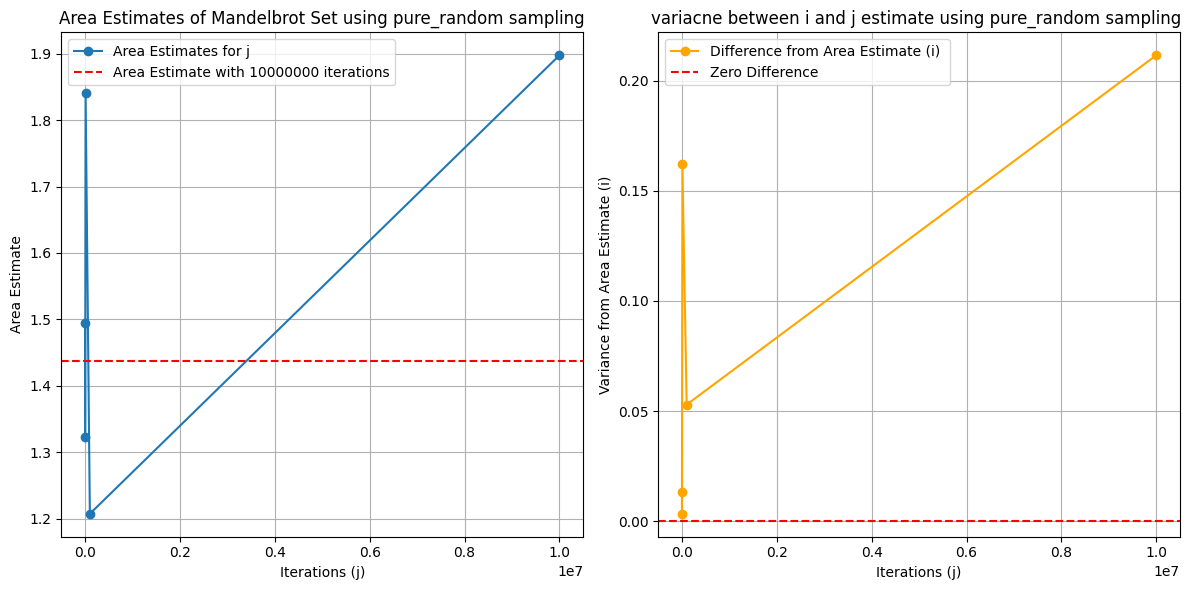

Estimated area for 100 samples and 10000000 iterations: 1.61
Monte carlo estimate of area Mandelbrot with 10000000 iterations: 1.61
testing for 100 iterations
Estimated area for 100 samples and 100 iterations: 1.4375
testing for 1000 iterations
Estimated area for 100 samples and 1000 iterations: 1.5525000000000002
testing for 10000 iterations
Estimated area for 100 samples and 10000 iterations: 1.5525000000000002
testing for 100000 iterations
Estimated area for 100 samples and 100000 iterations: 1.5525000000000002
testing for 10000000 iterations
Estimated area for 100 samples and 10000000 iterations: 1.61


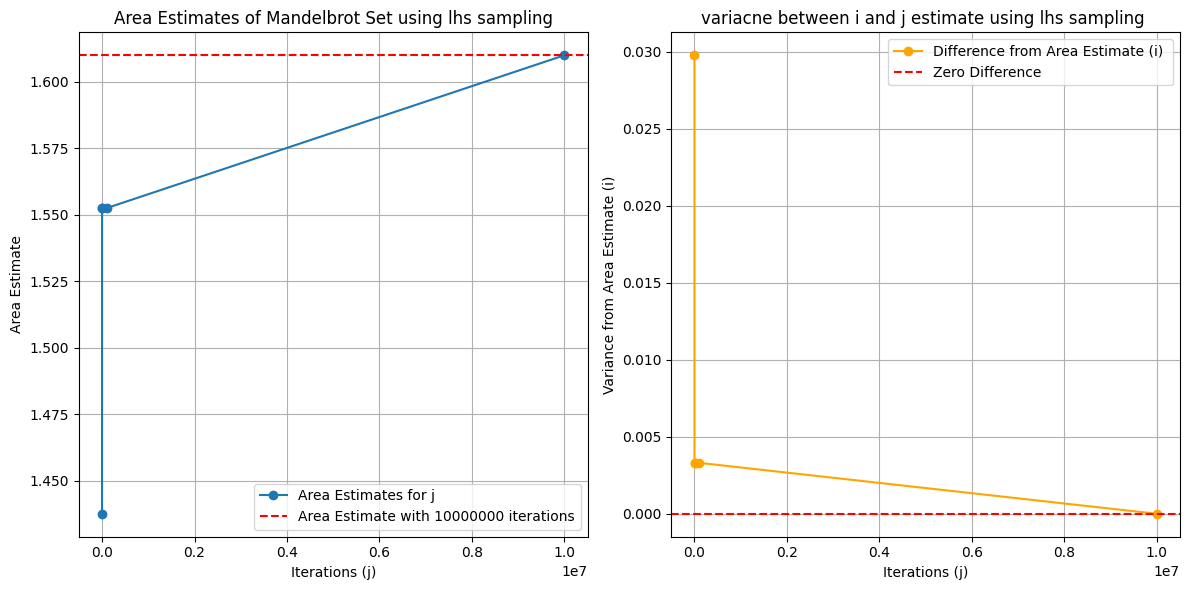

Estimated area for 100 samples and 10000000 iterations: 1.035
Monte carlo estimate of area Mandelbrot with 10000000 iterations: 1.035
testing for 100 iterations
Estimated area for 100 samples and 100 iterations: 1.035
testing for 1000 iterations
Estimated area for 100 samples and 1000 iterations: 1.035
testing for 10000 iterations
Estimated area for 100 samples and 10000 iterations: 1.035
testing for 100000 iterations
Estimated area for 100 samples and 100000 iterations: 1.035
testing for 10000000 iterations
Estimated area for 100 samples and 10000000 iterations: 1.035


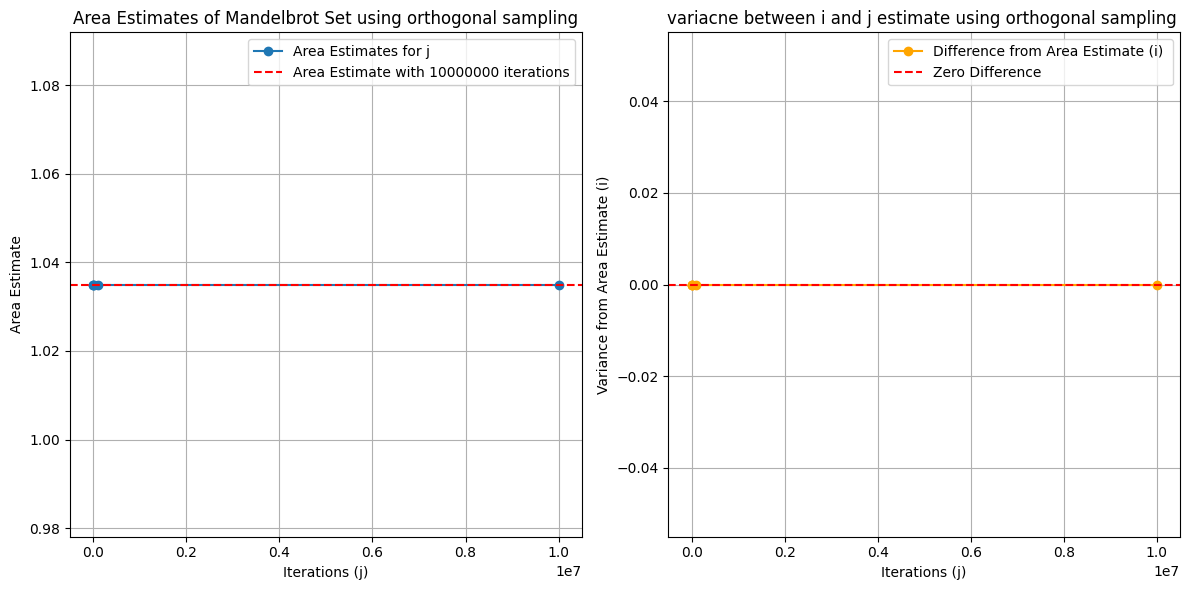

In [119]:

def compute_variance(area_setimate_i, area_estimate_j):
    squared_difference = (area_estimate_j-area_setimate_i) ** 2
    return squared_difference 

     


samples = 100
i = 10000000
j = [100, 1000, 10000, 100000, 10000000] 


def plot(i, j, samples, sample_type): 
    area_estimate_i = monte_carlo(samples,sample_type, i, y_min, y_max, x_min, x_max)
    print(f"Monte carlo estimate of area Mandelbrot with {i} iterations: {area_estimate_i}")
    j_estimates = [] 
    differences = []

    for setting in j:  
        print(f"testing for {setting} iterations")
        area_setting_j  = monte_carlo(samples,sample_type, setting, y_min, y_max, x_min, x_max)
        j_estimates.append(area_setting_j)
        variance = compute_variance(area_estimate_i, area_setting_j)
        differences.append(variance)

    plt.figure(figsize=(12, 6))

    #  j
    plt.subplot(1, 2, 1)
    plt.plot(j, j_estimates, marker='o', label=f'Area Estimates for j')
    plt.axhline(y=area_estimate_i, color='r', linestyle='--', label=f'Area Estimate with {i} iterations')
    plt.title(f'Area Estimates of Mandelbrot Set using {sample_type} sampling')
    plt.xlabel('Iterations (j)')
    plt.ylabel('Area Estimate')
    plt.legend()
    plt.grid(True)

    # differences
    plt.subplot(1, 2, 2)
    plt.plot(j, differences, marker='o', color='orange', label=f'Difference from Area Estimate (i) ')
    plt.axhline(y=0, color='r', linestyle='--', label='Zero Difference')
    plt.title(f'variacne between i and j estimate using {sample_type} sampling ')
    plt.xlabel('Iterations (j)')
    plt.ylabel('Variance from Area Estimate (i)')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    
        


plot(i, j, samples, "pure_random")
plot(i, j , samples, "lhs")
plot(i, j, samples, "orthogonal")

